In [56]:
#++++++++++++++++++++++++++++++++++++++++++++++
# Before running the script, edit 
# 'SET HYPERPARAMETERS' 
# - the rest is automated
#++++++++++++++++++++++++++++++++++++++++++++++

##################
### IMPORT MODULES
##################

### System
import sys
import os
from fnmatch import fnmatch 

### I/O
import json
import pickle

### General Processing
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import math
import collections
from collections import OrderedDict
from collections import namedtuple
DottedDict = namedtuple

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd
from sklearn.model_selection import train_test_split

### NLU
from ibm_watson import NaturalLanguageUnderstandingV1 as NaLaUn
from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions

### Presentation / apps
from matplotlib import pyplot as plt
import seaborn as sns

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import dash_table.FormatTemplate as FormatTemplate
from dash_table.Format import Sign
from dash.dependencies import Input, Output

import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

## GENERAL FUNCTIONS 

### SELECTION
def random_split(lst,split=0.5):
    shuffled = np.array(lst)
    np.random.shuffle(shuffled)
    split    = int(split * len(shuffled))
    return  shuffled[-split:] , shuffled[:-split]

### NORMALIZATION
#### Statistic normalization - subtract mean, scale by standard deviation
def norm_stat(vec, weights = False):
    '''
    Normalizes a vector v-v.mean())/v.std() 
    '''
    if weights:
        return  np.mean(abs(vec - vec.mean()))  
    return (vec-vec.mean())/vec.std()

#### Algebraic normalization - dot product
def norm_dot(vec, weights = False):
    '''
    Normalizes a vector - dot product: v @ v = 1
    '''
    if weights:
        return  np.sqrt(vec @ vec)
    
    return vec / np.sqrt(vec @ vec)

#### Algebraic normalization - dot product
def norm_sum(vec, weights = False):
    '''
    Normalizes a vector - sum: v.sum = 1
    '''
    if weights:
        return  vec.sum()
    
    return vec / vec.sum()

#### Scaled Normalization -
def scale(vec, weights = False):
    '''
    Normalizes a vector: v.min = 0, v.max = 1
    '''
    stop_divide_by_zero = 0.00000001
    if weights:
        return (vec.max()-vec.min() + stop_divide_by_zero)
    return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)
def cleanup_chars(string,char_list = ('\n',' ')):
    result = string
    for char in char_list:
        result = result.replace(char,'')
    return result

### Matrix operations

def dotdf(df1,df2):
    '''
    performs df1 @ df2 without exceptions, when df1.columns and df2.index are not identical
    '''
    c = set(df1.columns)
    i = set(df2.index)
    var = list(c - (c - i))
    return df1[var] @ df2.loc[var]

### OS system commands

from fnmatch import fnmatch 
def ls(search,name_only = False):
    '''
    emulates unix ls (without flags). Accepts wildcard/'*' in 
    '''
    search_split = search.replace('/','/ ').split()
    pattern      =         search_split[ -1]
    path         = ''.join(search_split[:-1])
    all_names    = np.array(os.listdir(path)) # numpy array enables Boolean Mask
    if not name_only: # add path to each name
        all_names    = np.array([path+name for name in all_names]) 
    mask         = [fnmatch(name,pattern) for name in all_names]
    result       = all_names[mask]
    return result

##########################################
### IBM-WATSON/NLU API-KEY (DON'T EDIT)
##########################################
# The script asks for the API key when run. 
# Do NOT save API-Keys in the code. 

local_dir_exists = os.path.exists('.local')
if not local_dir_exists:
    os.mkdir('.local')
    
credentials_exists = os.path.exists('.local/crd.env')
if not credentials_exists:
    print('Credentials needed for https://cloud.ibm.com/catalog/services/natural-language-understanding )')
    apikey = input(prompt='API-Key?')
    apiurl = input(prompt='API-URL?')
    crd = open('.local/crd.env','w')
    crd.write(  'NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY='+apikey)
    crd.write('\nNATURAL_LANGUAGE_UNDERSTANDING_URL='       +apiurl)  
    

# dian_pkl_file = PATH['results']+'all_dictations_nlu.pkl'  
# dian_pkl_exists = os.path.exists(dian_pkl_file)
# if 'apikey' not in locals():
#     apikey = input(prompt='API-Key? ( https://cloud.ibm.com/catalog/services/natural-language-understanding )')  


# # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# ## Use non-zero matrix factorization for clustering
# ## Use singular value decomposition first state for determining overall similarity

class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
              
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - Dot-Normalized archetypes  
        
        my_archetypes.o         - documents x archetypes matrix (from w-matrix) 
        my_archetypes.on        - Sum-Normalized documents
        
    '''
    
    def __init__(self,X,n,
                 norm         = norm_dot,
                 bootstrap    = False,     bootstrap_frac = 0.5,
                 random_state = None):
        self.n = n
        self.X = X
        self.norm = norm
        self.random_state = random_state
        
        if bootstrap:
            self.bootstrap_n    = bootstrap
            self.bootstrap_frac = bootstrap_frac
        else:
            self.bootstrap_n    = 1
            self.bootstrap_frac = 1
        
        self.model = NMF(n_components=n, init='random', random_state=self.random_state, max_iter = 1000, tol = 0.0000001)
        self.w_dic = {}
        self.o_dic = {}
        self.h_dic = {}
        self.f_dic = {}   
        
        for j in range(self.bootstrap_n): 
            XX = self.X.sample(int(len(self.X) *self.bootstrap_frac))
            self.w_dic[j] = self.model.fit_transform(XX)
            self.o_dic[j] = pd.DataFrame(self.w_dic[j],index=XX.index)
            self.h_dic[j] = self.model.components_
            self.f_dic[j] = pd.DataFrame(self.h_dic[j],columns=XX.columns)
        
        self.w  = self.w_dic[0]  # TEMPORARY
        self.o  = self.o_dic[0]  # TEMPORARY
        self.h  = self.h_dic[0]  # TEMPORARY
        self.f  = self.f_dic[0]  # TEMPORARY
 
        
        self.fn          = self.f.T.apply(norm_dot).T    # under construction - David
        self.on          = self.o.T.apply(norm_sum).T
        self.norm_matrix = self.fn @ self.fn.T           # under construction - David
        self.arch_basis  = self.norm_matrix.T @ self.fn  # under construction - David


class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: f=original features x svd_features
        my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
        my_svd.volume(keep_volume) 
                        - collections.namedtuple ('dotted dicionary'): 
                          Dimensionality reduction. keeps 'keep_volume' of total variance
                          
                          
    '''
    def __init__(self,X,):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
    def volume(self,keep_volume):
        ''' 
        Dimensionality reduction, keeps 'keep_volume' proportion of original variance
        Type: collections.namedtuple ('dotted dictionary')
        Examples of usage:
        my_svd.volume(0.9).s - np.array: eigenvalues for 90% variance 
        my_svd.volume(0.8).f - dataframe: features for 80% variance
        my_svd.volume(0.5).o - dataframe: occupations for 50% variance      
        '''
        dotted_dic = collections.namedtuple('dotted_dic', 's f o')
        a1 = self.s.cumsum()
        a2 = a1/a1[-1]
        n_max = np.argmin(np.square(a2 - keep_volume))
        cut_dic = dotted_dic(s= self.s[:n_max],f= self.f.iloc[:n_max], o= self.o.iloc[:n_max])
        return cut_dic
        

##########################
## SET HYPERPARAMATERS
#### edit below ##########

# Import credentials
cred = open('.local/crd.env','r').read()
apikey,apiurl = cred.replace('NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY=','').replace(
                            'NATURAL_LANGUAGE_UNDERSTANDING_URL=','').split()

PATH = {}
PATH['data']    = '../data/Documents/'
PATH['results'] = './Watson-nlu-results/'

NLU = {}
NLU['apikey']         = apikey
NLU['apiurl']         = apiurl
NLU['version']        = '2019-07-12'
NLU['features']       = Features(
                        categories= CategoriesOptions(),
                        concepts  = ConceptsOptions(),
                        entities  = EntitiesOptions(),
                        keywords  = KeywordsOptions(),
                        relations = RelationsOptions(),
                        syntax    = SyntaxOptions()
                        )


class WatsonDocumentArchetypes:
    '''
    WatsonDocumentArchetypes performs Archetypal Analysis on a corpus consisting of a set of documents, for example a set 
    of articles, books, news stories or medical dictations.
    
    Input parameters:
    
    PATH            - Dictionary with paths to I/O
    PATH['data']    - Directory for input text files. Example: './data/input_texts/'
    PATH['results'] - Directory for output.           Example: './data/output_nlu/'
    
    NLU                   - Dictionary with information for running Watson NLU
    NLU['apikey']         - apikey for running Watson NLU
    NLU['apiurl']         - URL for Watson NLU API
    NLU['version']        - Watson NLU version, e.g. '2019-07-12'
    NLU['features']       - Features requested from Watson NLU for each document in the set, e.g. 
                                Features(
                                categories= CategoriesOptions(),
                                concepts  = ConceptsOptions(),
                                entities  = EntitiesOptions(),
                                keywords  = KeywordsOptions(),
                                relations = RelationsOptions(),
                                syntax    = SyntaxOptions()
                                )

    Attributes:

        
        self.PATH 
    
        
    '''
    from ibm_watson import NaturalLanguageUnderstandingV1 as NaLaUn
    from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions
    
    def __init__(self, PATH, NLU, 
                 train_test = False,
                 random_state = None):
        
        self.PATH         = PATH
        self.NLU          = NLU
        self.random_state = random_state      
        # To random partition documents into train/test-sets, 
        # choose relative size of test-set, train_test (1 = 100%)
        self.train_test = train_test  
        
        self.nlu_model  = NaLaUn(version=NLU['version'] , iam_apikey = NLU['apikey'], url = NLU['apiurl'])  #Local Natural Language Understanding object
            # Initiate X_matrix dictionaries
        self.X_matrix_dic = {}
        self.X_matrix_train_dic = {}
        self.X_matrix_test_dic  = {}
        self.archetypes_dic = {} 
        self.svd_dic = {}
 
        ################
        ## PREPARE DATA 
        ################
        self.filenames = ls(self.PATH['data']+'*.txt', name_only=True)  # all filenames ending with '.txt' 
        self.names     = [name.replace('.txt','') for name in self.filenames]
        self.all_names = self.names *1      # if train_test - self.names will be set to self.names_train
        self.dictation_dic = {}             # dictionary for dictation files
        for name in self.filenames:
            self.dictation_dic[name.replace('.txt','')] = open(self.PATH['data']+name, encoding="utf-8").read()
        self.dictation_df = pd.Series(self.dictation_dic)
            
        ####################
        ## TRAIN-TEST SPLIT 
        ####################
        if self.train_test: # 0<train_test<1 - the proportion of names to save as 'test (rounded downwards)
            self.names_test , self.names_train = random_split(self.all_names , self.train_test)
            self.names = self.names_train

        ###############################
        ## PERFORM WATSON NLU ANALYSIS
        ###############################
        
# QQQQQQQQQQQQQQQQQQ TODO QQQQQQQQQQQQQQQQQQ
#   * IF DICTATION ALREADY HAS PKL WITH Watson NLU: READ EXISTING PKL. SKIP NEW WATSON CALC.
#
 
        self.watson = {}    #Dictionary with Watson-NLU results for each dictation
        
        self.watson_pkl = PATH['results']+'all_dictations_nlu.pkl'  
        pkl_exists = os.path.exists(self.watson_pkl)

        if pkl_exists:
            self.watson = pickle.load( open( self.watson_pkl, "rb" ) )

        else: #perform nlu-analysis on dictations
            for item in list(self.dictation_dic.items()):
                lbl  = item[0]
                text = item[1]
                self.watson[lbl] = self.nlu_model.analyze(text = text, features=NLU['features'])
                f = open(PATH['results']+str(lbl)+'_nlu.pkl','wb')
                pickle.dump(self.watson[lbl],f)
                f.close()

            f = open(self.watson_pkl,'wb')
            pickle.dump(self.watson,f)
            f.close() 

        # Copy Watson NLU results to Pandas Dataframes
        self.watson_nlu = {}
        for dctn in self.watson.items():
            self.watson_nlu[dctn[0]] = {}
            for item in list(dctn[1].result.items()):
                self.watson_nlu[dctn[0]][item[0]]=pd.DataFrame(list(item[1]))


    ##############
    # ARCHETYPAL ANALYSIS
    ##############

    # CONSTRUCT X- MATRIX
    def X_matrix(self,typ = 'entities'):
        '''
        Construct the archetypal analysis X-matrix by pivoting the dataframe in the 
        dictionary my_wda.watson_nlu that contains the Watson NLU analysis in question
        
        X_matrix(typ)
            rows   : Dictations 
            columns: Variables; keywords/entities/concepts, from Watson NLU analysis
            values : Weights, from Watson NLU analysis
        
        the constructed X_matrix(typ) is saved as X_matrix_dic[typ]
        
        if my_wda.train_test has a value (not False) X_matrix_train_dic[typ] and X_matrix_test[typ]
        are added computed and added to their respective dicionaries
        '''
        if typ not in self.X_matrix_dic.keys():
            df = pd.DataFrame()
            for key in self.names:
                dfx = self.watson_nlu[key][typ].copy()
                dfx['dictation'] = key
                df = df.append(dfx,sort=True)
            if typ is 'entities':
                df = df[df['type']=='HealthCondition']
                df.rename({'relevance': 'rel0'}, axis=1,inplace=True)
                df['relevance'] = df['rel0'] * df['confidence']
            self.X_matrix_dic[typ] = df.pivot_table(index='dictation',columns='text',values='relevance').fillna(0)
        
        if self.train_test:
            self.X_matrix_train_dic[typ] = self.X_matrix_dic[typ]
            
            df = pd.DataFrame()
            for key in self.names_test:
                dfx = self.watson_nlu[key][typ].copy()
                dfx['dictation'] = key
                df = df.append(dfx,sort=True)
            if typ is 'entities':
                df = df[df['type']=='HealthCondition']
                df.rename({'relevance': 'rel0'}, axis=1,inplace=True)
                df['relevance'] = df['rel0'] * df['confidence']
            self.X_matrix_test_dic[typ] = df.pivot_table(index='dictation',columns='text',values='relevance').fillna(0)
        return self.X_matrix_dic[typ]

    # CALCULATE ARCHETYPES
    def archetypes(self,typ='entities',
                   n_archs=6,bootstrap = False, 
                   bootstrap_frac = 0.5, 
                   random_state = False,
                   norm = norm_sum):
        if random_state is False:
            random_state = self.random_state
        if typ not in self.archetypes_dic.keys():
            self.archetypes_dic[typ] = {}
        hyperparam = (n_archs,bootstrap,bootstrap_frac,random_state,norm)
        self.X_matrix(typ)
        self.archetypes_dic[typ][hyperparam] = Archetypes(self.X_matrix(typ),
                                                          n_archs,bootstrap = bootstrap, bootstrap_frac = bootstrap_frac,
                                                          random_state = random_state,
                                                          norm = norm)
        return self.archetypes_dic[typ][hyperparam]


    def display_archetype(self,arch_nr = -1, typ = 'entities' , n_archs = 6, var = 'variables', threshold = 0.10, norm = scale):
        fun = {'variables' : 'self.archetypes(typ = typ,n_archs = n_archs).f.T ',
               'dictations': 'self.archetypes(typ = typ,n_archs = n_archs).o'
               }
        f  = eval(fun[var])
        fn = f.apply(norm)
        if arch_nr == -1:
            return sns.clustermap(f).data2d
        else:
            arc        = fn.sort_values(by=arch_nr,ascending = False)
            if norm is norm_sum :  # normalized over sum: threshold is ignored volume
                arc_cs     = arc[arch_nr].cumsum() 
                thresh_idx = abs(arc_cs -(1- threshold)).values.argmin()
                result     = arc.iloc[:thresh_idx]
            if norm is scale :
                result = arc[
                            arc[arch_nr] >= (threshold * arc[arch_nr][0])                  ]
        return result

    
    # CALCULATE SVD
    def svd(self,typ='entities'):
        self.X_matrix(typ)
        self.svd_dic[typ] = Svd(self.X_matrix(typ))
        return 
    
    # ANALYZE A TEXT
    def analyze(self,text,typ='entities'):
        pass

In [2]:
### Note: the app below has been replaced by Seaborn plots in the following example. 
### This code had not been upated recently, but is *mostly* functional

## DASH/PLOTLY  WEB APP
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
application = app.server
app.title = 'IBM Watson – Natural Language Understanding'

app.layout = html.Div(
    html.Div([
        html.Div([
            html.H1(children='DICTATION-NLU',
                    className = "nine columns",
                    style={
                    'margin-top': 20,
                    'margin-right': 20
                    },
            ),
            
            dcc.Markdown(children='''
                        Archetypal Analysis of Medical Dictations. Process:
                        1. **Natural Language Understanding**:
                            - Dictations are analyzed by IBM Watson Natural Language Understanding. 
                            - Output variables: keywords, entities, concepts and categories.
                        2. **Archetypal Analysis**:
                            - Create Archetypes: Cluster data over variables, using NMF Non-zero Matrix Factorization
                            - *Try using TSNE*
                            - Dictations and variables are mapped onto the Archetypes/clusters
                        ''',
                    className = 'nine columns')
        ], className = "row"),
        html.Div([
            html.H2(children='ARCHETYPES:VARIABLES',
                    className = "nine columns",
                    style={
                    'margin-top': 20,
                    'margin-right': 20
                    },
            )
        ], className = "row"),
        html.Div(
                    [
                        html.Label('Variables', style={'font-weight' : 'bold'}),
                        dcc.Dropdown(
                            id = 'Var',
                            options=[
                                {'label': 'Keywords'  ,'value': 'keywords'},
                                {'label': 'Entities'  ,'value': 'entities'},
                                {'label': 'Concepts'  ,'value': 'concepts'},
                                # {'label': 'Categories','value': 'categories'}, # Watson exists, ARCHETYPES NEED TO BE IMPLEMENTED 
                            ],
                            value = 'keywords',
                        ) 
                    ],
                    className = 'two columns',
                    style={'margin-top': '30'}
                ),
        html.Div(
            [
                html.Div(
                    [
                        html.Label('#Archetypes', style={'font-weight' : 'bold'}),
                        dcc.Dropdown(
                            id = 'NoA',
                            options=[{'label':k,'value':k} for k in range(2,100)],
                            value = 6,
                            multi = False
                        ) 
                    ],
                    className = 'one columns offset-by-one',
                    style={'margin-top': '30'}
                ),
                html.Div(
                    [
                        html.Label('Cut at', style={'font-weight' : 'bold'}),
                        dcc.Dropdown(
                            id = 'Threshold',
                            options=[{'label':str(k)+'%','value':k/100} for k in range(1,99)],
                            value = 0.1,
                            multi = False
                        ) 
                    ],
                    className = 'one columns offset-by-one',
                    style={'margin-top': '30'}
                ),
            ], className="row"
        ),
        html.Div([
            html.Div([
                dcc.Graph(
                    id='variables-heatmap'
                )
            ])
        ]),
        # html.Div([
        #     html.H3('DICTATIONS MAPPED ONTO ARCHETYPES'),
        #     dcc.Graph(id='dictations')
        # ])
     ])
)


@app.callback(
    dash.dependencies.Output('variables-heatmap', 'figure'),
    [dash.dependencies.Input('Var', 'value'),
     dash.dependencies.Input('NoA', 'value'),
     dash.dependencies.Input('Threshold', 'value')]
)

def arch_heatmap_variables(typ, n_archs, threshold):
    variables = (typ,n_archs,threshold)

    # def f(i):
    #     return display_archetype(arch_nr=i,typ=typ,n_archs=n_archs,threshold=threshold).sort_values(by=i) #Sort by archetype i
    def f(i):
        return dan.display_archetype(arch_nr=i,typ=typ,n_archs=n_archs,threshold=threshold).sort_values(by=i) #Sort by archetype i
    maxrows = int(1+ n_archs//3)
    cols = 3
    fig = make_subplots(rows=maxrows, cols=cols, horizontal_spacing=0.2)  
    for i in range(n_archs):
        fig.add_trace( go.Heatmap(  z = f(i),
                                    y = f(i).index,
                                    x = f(i).columns,
                                    xgap = 1,
                                    ygap = 1,
                        ), col = i%cols +1,row = int(i//cols)+1
            )
    fig.update_layout(height=400*maxrows, width=1200, title_text="Subplots")
    return fig



# @app.callback(
#     dash.dependencies.Output('dictations', 'figure'),
#     [dash.dependencies.Input('Var', 'value'),
#      dash.dependencies.Input('NoA', 'value'),
#      dash.dependencies.Input('Threshold', 'value')]
# )

# def arch_heatmap_dictations(typ, n_archs, threshold):
#     variables = (typ,n_archs,threshold)
#     f = archetypes(typ,n_archs).o
#     fig = go.Heatmap(   z = f
#             )
#     return fig



# #%%

# if __name__ == '__main__':
#     app.run_server(port=8080, debug=True)




# #%%

IndentationError: expected an indented block (<ipython-input-2-6c6bd471eabe>, line 114)

# Dimensionality: How diverse is the corpus?

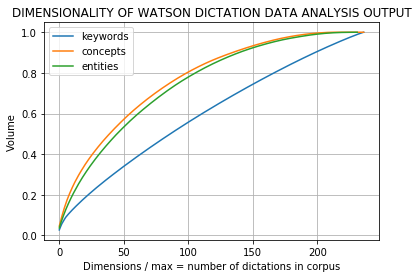

In [28]:
## David to team: as an extr feature, we can soncider includeing the dimensionality analyis - the plot - as a feature for analysis.


## INSTANTIATE THE WatsonDocumentArchetypes OBJECT as 'wda' 
# Split dictations into train/test-set with 5% set aside as test-dictations
# wda_a has no test-dictations, all are included in the corpus.

wda    = WatsonDocumentArchetypes(PATH,NLU,train_test = 0.05, random_state = 42)

wda_a  = WatsonDocumentArchetypes(PATH,NLU,train_test = False)


## DIMENSIONALITY OF THE CORPUS
# Establish with Singular Value Decomposition (principal component analysis) :

types = ['keywords','concepts','entities']
svde  = {}
volume = {}
volume_distribution = {}

for typ in types:
    svde[typ]     = Svd(wda.X_matrix(typ))
    volume[typ] = svde[typ].s.sum()
    volume_distribution[typ] = svde[typ].s.cumsum()/volume[typ]
    plt.plot(volume_distribution[typ],label = typ)
plt.title('DIMENSIONALITY OF WATSON DICTATION DATA ANALYSIS OUTPUT')
plt.xlabel('Dimensions / max = number of dictations in corpus')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

## COMMENT: CONCEPTS AND ENTITIES OFFER A GREATER REDUCTION OF DIMENSIONALITY = THE MODELS FIT THE DATA BETTER (?)
## ? => WE ARE MEASURING THE WATSON OUTPUT ONLY. WE DON'T KNOW WHAT IS GOING ON INSIDE WATSON. 

## CONCLUSIONS: 
## DICTATION WORD/ENTITY/CONCEPTUAL CONTENT IS DIVERSE AND SPREAD OVER MANY DIMENSIONS
## ACCESS TO A LARGER CORPUS SHOULD BE VERY GOOD!

### COMMENT: 

CONCEPTS AND ENTITIES OFFER A GREATER REDUCTION OF DIMENSIONALITY = THE MODELS FIT THE DATA BETTER (?)

? => WE ARE MEASURING THE WATSON OUTPUT ONLY. WE DON'T KNOW WHAT IS GOING ON INSIDE WATSON. 

## DIMENSIONALITY - CONCLUSIONS: 
- iN OUR EXISTING CORPUS, THE DICTATION WORD/ENTITY/CONCEPTUAL CONTENT IS DIVERSE AND SPREADS ACROSS MANY DIMENSIONS
- ACCESS TO A LARGER CORPUS SHOULD BE VERY GOOD!

# EXPLORING ARCHETYPES

When exploring the dimensionality of the problem we used SVD - the 'singular value decomposition' of a matrix of data. Now we move on to Archetypal analysis, a type of 'soft clustering'. 

The relationship between SVD and Archetypes/Cluster representations is not unlike the relation between waves and particles, where SVD is more like an overlay of multiple waves, like jpeg uses the fourier/cosine transform to decompose pictures, while Archetypes/Clusters are more like representing the picture as a sum of objects. The dimensionality distribution in SVD is not unlike the frequency distribution in a jpeg, although much less restricted. Fourier/Cosine transform has its basis functions predefined and has to stick to its delocalized functions, while SVD is more flexible in its choice of basis functions. The don't have to be delocalized, even if they often are. In fact, the clustering/Archetypal analysis trades information quality in return for intuitive interpretability. It is easier to understand a sum of objects than an overlay of waves. The key difference is that waves have phase, they have both negative and positive amplitude. Objects, on the other hand, never have negative presence - the presence of objects always add up, they can't cancel each other out like waves do. This explains the name of the method we use for computing the Archetypes/Clusters: "Non-Negative Matrix Factorization" (NMF). SVD factorizes a matrix into orthogonal components that can have either negative of positive matrix elements. NMF requires that all matrix elements are positive. NMF does, however, still allow delocalization. In straightforward clustering models, an element belongs to one or the other cluster. NMF is an example of "soft clustering" where an element can belong to several clusters, just like a word can belong to several overlapping categories. 

Since NMF has more restrictions than SVD, we assume that SVD is a lower limit for the dimensionality reduction that can be achieved through NMF. According to the same line of reasoning, the overlap between two different Archetypes/Soft Clusters can't be smaller than zero. The overlap between two different modes of 'waves' in SVD will always be zero. 

With this in mind we now identify the Archetypes of our corpus of dictations by computing the NMF-clusters. 

Here below we choose to partition our corpus into six archetypes. 

# BUILDING THE ARCHETYPES


In the plots below the different archetypes are shown and compared. Each plot is organized so that one (key) archetype is plotted in order from its largest variable and downwards. The other archetypes' values for the same components are shown for comparison. 

The list is truncated where the key archetype's component values go below 10% of the strongest component. 

## 1. FROM ENTITIES

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



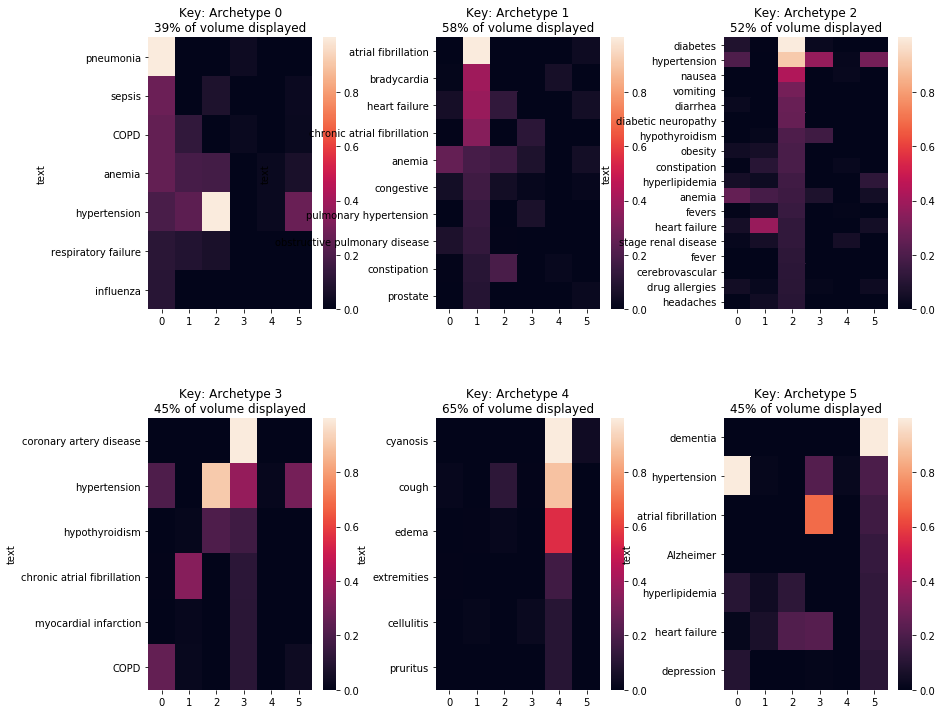

In [29]:
typ = 'entities'
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_archs   = 6
threshold = 0.1
for i in range(n_archs):
    tot = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(scale)[i].sum()
    f =   wda.display_archetype(typ = typ,n_archs=n_archs, arch_nr=i, threshold = threshold, norm = scale)
    ax = fig.add_subplot(2, 3, i+1)
    ax.title.set_text('Key: Archetype '+str(i)+'\n'+str(int(100*f[i].sum()/tot))+'% of volume displayed')
    sns.heatmap(f)
fig.show()

## 2. FROM CONCEPTS

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



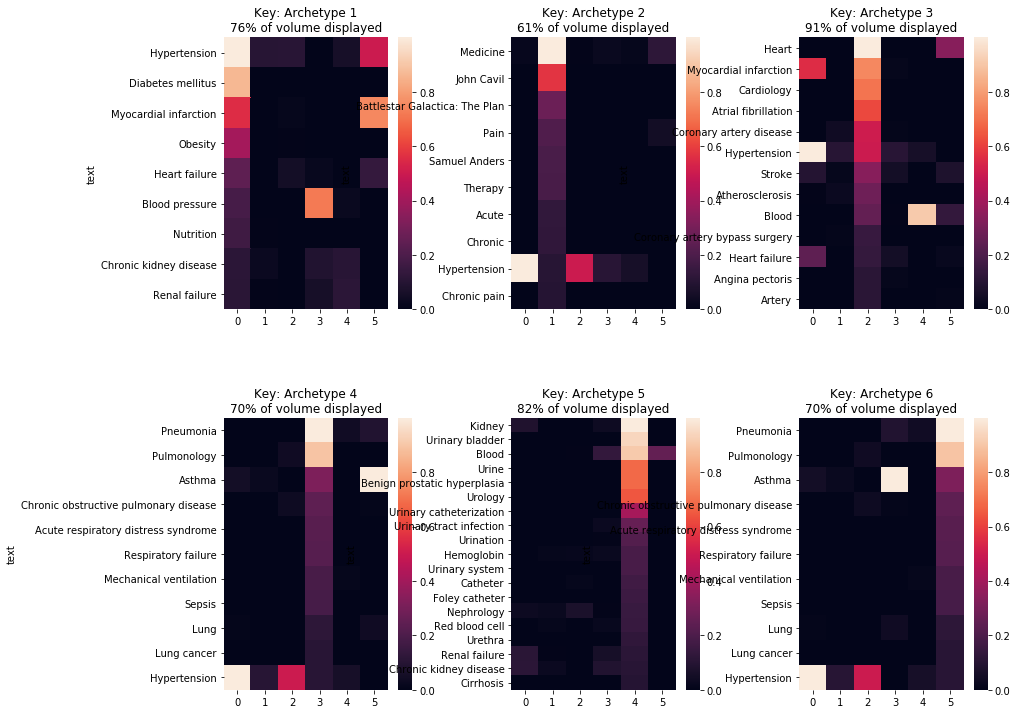

In [31]:
typ = 'concepts'
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_archs   = 6
threshold = 0.1
for i in range(n_archs):
    tot = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(scale)[i].sum()
    f =   wda.display_archetype(typ = typ,n_archs=n_archs, arch_nr=i, threshold = threshold, norm = scale)
    ax = fig.add_subplot(2, 3, i+1)
    ax.title.set_text('Key: Archetype '+str(i+1)+'\n'+str(int(100*f[i].sum()/tot))+'% of volume displayed')
    sns.heatmap(f)
fig.show()

## 3. FROM KEYWORDS


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



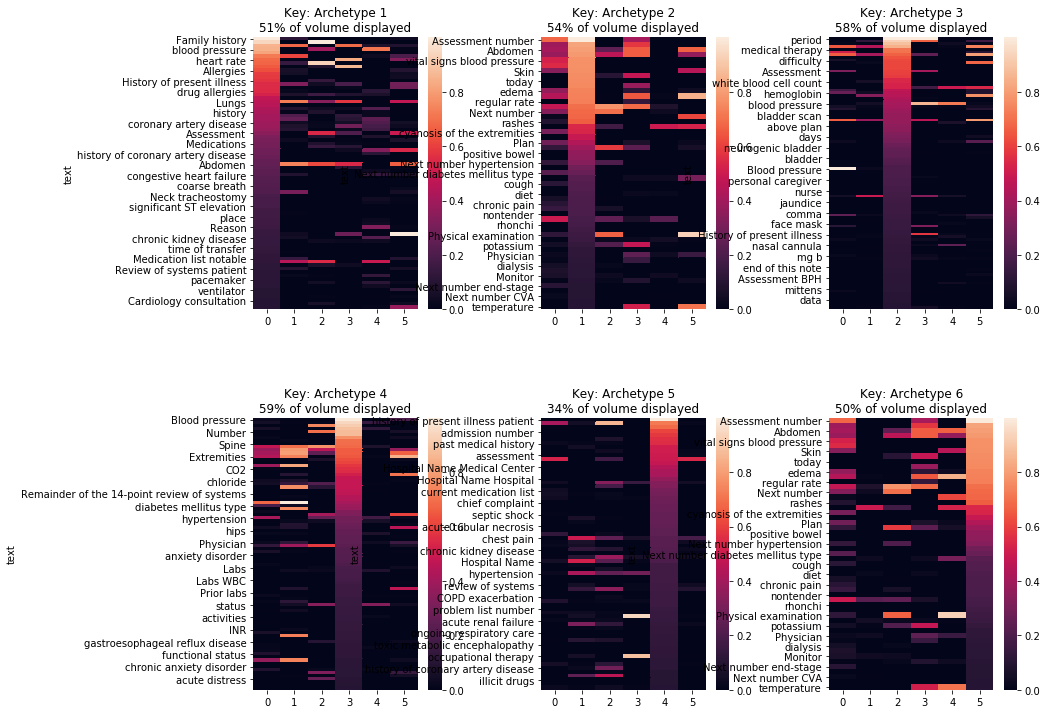

In [33]:
typ = 'keywords'
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_archs   = 6
threshold = 0.1
for i in range(n_archs):
    tot = wda.archetypes(typ = typ,n_archs=n_archs).f.T.apply(scale)[i].sum()
    f =   wda.display_archetype(typ = typ,n_archs=n_archs, arch_nr=i, threshold = threshold, norm = scale)
    ax = fig.add_subplot(2, 3, i+1)
    ax.title.set_text('Key: Archetype '+str(i+1)+'\n'+str(int(100*f[i].sum()/tot))+'% of volume displayed')
    sns.heatmap(f)
fig.show()

# USING THE ARCHETYPES AS A COORDINATE SYSTEM FOR DOCUMENTS

We apply hierarchical clustering (dendrograms) to organize the dictations so that the clustering ones are put next to each other. We see that they are quite distinct. 

The columns represent the six archetypes, he rows are the dictations. 

The dictations are normalized so that the sum of coefficients over the archetypes sum up to exactly one for each dictation. A row with a completely white segment will therefore be completely black otherwise, indicating that 100% of he dictation belongs to the 'white' archetype. 

## ENTITY-ARCHETYPES

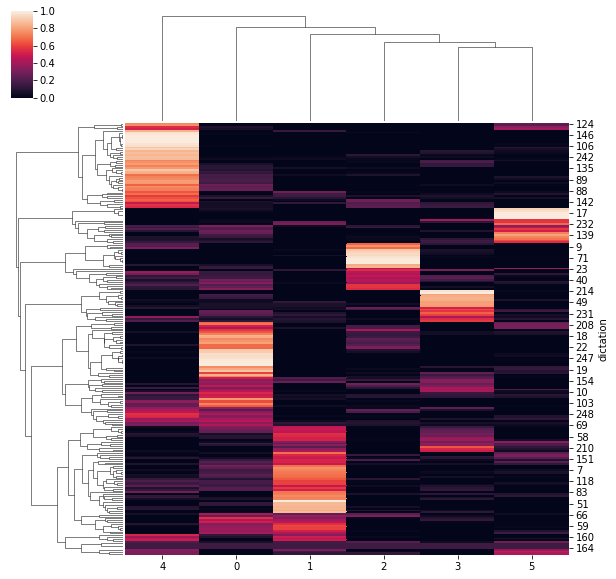

In [35]:
## ARCHETYPES based on ENTITIES in corpus texts
typ = 'entities'
n_archs = 6
f = wda.archetypes(typ=typ,n_archs=n_archs).o.applymap(lambda X: X+0.00000000000000001).T
sns.clustermap(f.apply(norm_sum).T)

## CONCEPT - ARCHETYPES

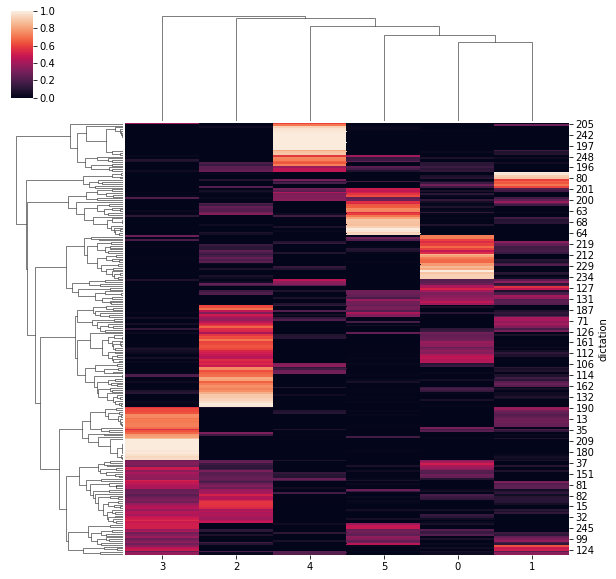

In [13]:
## ARCHETYPES based on CONCEPTS in corpus texts
typ = 'concepts'
n_archs = 6
f = wda.archetypes(typ=typ,n_archs=n_archs).o.applymap(lambda X: X+0.00000000000000001).T
sns.clustermap(f.apply(norm_sum).T)

## KEYWORD-ARCHETYPES 

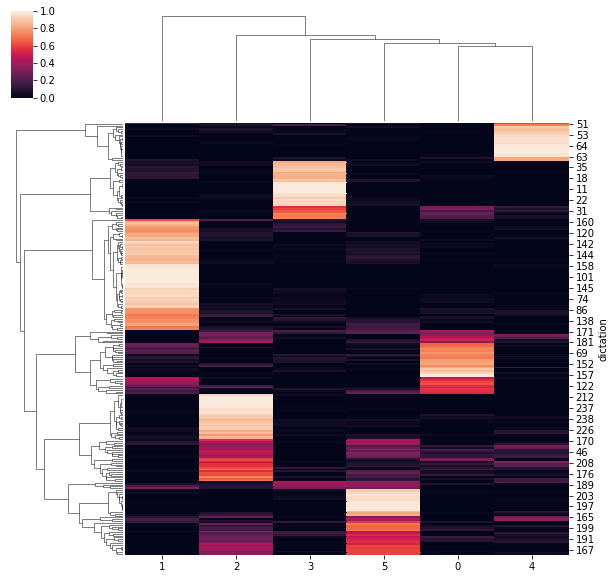

In [42]:
## ARCHETYPES based on KEYWORDS in corpus texts
typ = 'keywords'
n_archs = 6
f = wda.archetypes(typ=typ,n_archs=n_archs).o.applymap(lambda X: X+0.00000000000000001).T
sns.clustermap(f.apply(norm_sum).T)

# ANALYZING NEW DOCUMENTS 

**SCENARIO**: 
1. A physician dictates notes after examining a patient. 
2. The dictation is automatically transcribed. 
3. The dictation (transcript) is analyzed by Watson NLU, returning entities/concepts/keywords as shown above.
4. The analysis is mapped onto the archetypes shown above and returned to the physician. 

Note that we do not include the new document in the corpus.

Here we will go through steps 3-4, assuming that 1-2 have already been performed. 

## 2. Analyzing a New Transcript

We emulate a new transcript by picking one from our test set. Not included in the corpus. 



In [278]:
## We emulate a new transcript by picking one from our test set. Not included in the corpus. 

test_name = wda.names_test[1]

test_text = wda.dictation_df.loc[test_name]
test_text



"Reason for consultation is paroxysmal atrial fibrillation.\n\nHistory of present illness the patient's history is obtained from the medical record as well as interviewing the patient {period} The patient is a 70-year-old gentleman who has a history of hypertension, hyperlipidemia who was admitted to an outside hospital with an acute pontine stroke {period} The patient was initially treated and required endotracheal intubation {period} The patient subsequently has recovered somewhat although now is still with a tracheostomy and a PEG tube {period} The patient is awake and alert {period} He denies any chest pain {period} He reports occasional palpitations {period} He denies any knowledge of any prior cardiac history {period} The patient continues to have productive cough {period}\n\nPast medical history number one hypertension number two hyperlipidemia next number borderline obesity next number acute stroke.\n\nAllergies no known drug allergies.\n\nMedication include, aspirin 325 mg dai

## 3. RUN WATSON NLU ON TEST DOCUMENT

In [283]:
## DAVID TO TEAM: See self.watson and self.watson_nlu - which does the Watson analysis 
## for all documents in the corups. Reuse code?.



# ## Call Watson API
# def watson_nlu(text, 
#                typ_list = ['entities','concepts','keywords']):
#     module = wda.nlu_model.analyze(text = text, features=NLU['features'])
#     result = {}
#     for typ in typ_list:
#          result[typ] = pd.DataFrame(module.result[typ])
#     return result

# test_watson = watson_nlu(test_text)

test_watson = wda.watson_nlu[test_name]
test_watson
    

{'usage':                  0
 0       text_units
 1  text_characters
 2         features,
 'relations':                                             arguments     score  \
 0   [{'text': 'patient', 'location': [173, 180], '...  0.597486   
 1   [{'text': 'gentleman', 'location': [219, 228],...  0.847566   
 2   [{'text': 'gentleman', 'location': [1355, 1364...  0.513276   
 3   [{'text': 'BUN', 'location': [1942, 1945], 'en...  0.969621   
 4   [{'text': '{', 'location': [2060, 2061], 'enti...  0.680507   
 5   [{'text': '{', 'location': [2180, 2181], 'enti...  0.700796   
 6   [{'text': '}', 'location': [2067, 2068], 'enti...  0.499136   
 7   [{'text': '} Number', 'location': [2295, 2303]...  0.949155   
 8   [{'text': 'smoker', 'location': [2416, 2422], ...  0.540444   
 9   [{'text': 'smoker', 'location': [2416, 2422], ...  0.614960   
 10  [{'text': '{', 'location': [2723, 2724], 'enti...  0.676827   
 11  [{'text': '} Number', 'location': [2673, 2681]...  0.685278   
 12  [{'text'

In [302]:
test_watson['concepts']

,dbpedia_resource,relevance,text
0,http://dbpedia.org/resource/Stroke,0.953394,Stroke
1,http://dbpedia.org/resource/Atrial_fibrillation,0.778061,Atrial fibrillation
2,http://dbpedia.org/resource/Heart,0.634186,Heart
3,http://dbpedia.org/resource/Hypertension,0.561630,Hypertension
4,http://dbpedia.org/resource/Myocardial_infarction,0.531054,Myocardial infarction
5,http://dbpedia.org/resource/Medical_history,0.513183,Medical history
6,http://dbpedia.org/resource/Asthma,0.499743,Asthma
7,http://dbpedia.org/resource/Cardiology,0.464348,Cardiology


In [285]:
## Construct the 'concepts'-word vector

test_vec = test_watson['concepts'].set_index('text')[['relevance']].apply(norm_dot)
test_vec

,relevance
text,
Stroke,0.529443
Atrial fibrillation,0.432076
Heart,0.352179
Hypertension,0.311887
Myocardial infarction,0.294907
Medical history,0.284983
Asthma,0.277520
Cardiology,0.257864


## 4. MAP TEST DOCUMENT ON ARCHETYPES 

### 1:  Similarities to Archetypes

We project the test document onto the Archetypes by using **cosine similarities** showing 'how similar' the document is to an archetype. The similarity between an archetype vector **a** and the test document vector **d** is 

$$\text{similarity} = {\mathbf{a} \cdot \mathbf{d} \over \|\mathbf{a}\| \|\mathbf{d}\|}= \mathbf{\widehat{a}} \cdot \mathbf{\widehat{d}} $$

where the 'hat' represents 'dot-normalized' vectors, such that $ \mathbf{\widehat{a}} \cdot \mathbf{\widehat{a} = 1}$

**NOTE** that, since the Archetypes are NOT an orthogonal set, projecting the test document onto the Archetypes, i.e. saying 'the test document is this much similar to the first archetype and that much similar to the second archetype' is *NOT* the same as saying 'the test vector can be described as a sum of this much of the first archetype and that much of the second archetype. Because the archetypes have overlap, the overlapping similarities will be erroneously amplified, multiplied by the summation. Consider: A mule is half horse and half donkey. A mule on a hill is half a horse on a hill and half a donkey on a hill, but don't sum that up to a half a horse and half a donkey on *two* hills. When using Archetypes as a basis set, this will be taken into account. We do this in "Archetypes as a basis set"

Here we will only look at the **projections / similarities** between a document and the archetypes. 

In [286]:
archetypes = wda.archetypes(typ='concepts',n_archs=6)

In [287]:
archetypes.f

text,2,Abdomen,Abdominal pain,Abnormal psychology,Acinetobacter,Acromion,Acupuncture,Acute,Acute respiratory distress syndrome,Addiction,...,Vital signs,Vitamin D,Vomiting,Vulva,Warfarin,West Nile virus,Wheeze,White blood cell,Wrist,Zenker's diverticulum
0,0.000000,0.000000,0.034306,0.000000,0.001935,0.000000,0.018495,0.000000,0.000000,0.013838,...,0.000000,0.062153,0.040278,0.000000,0.000000,0.000000,0.00772,0.000000,0.000000,0.000000
1,0.064386,0.000000,0.016413,0.024851,0.000000,0.000053,0.044835,0.535934,0.000000,0.000000,...,0.000000,0.130613,0.000000,0.006525,0.000000,0.000000,0.00000,0.000000,0.000687,0.000000
2,0.000000,0.000190,0.000000,0.000000,0.091693,0.000049,0.000000,0.000000,0.411694,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.018008,0.000000,0.000000
3,0.004195,0.000243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.861112,0.125784,0.032799,0.000000,0.000000,0.000000,0.03378,0.010133,0.000358,0.010817
4,0.000000,0.000415,0.058779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058865,0.00000,0.045323,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000120,0.028422,0.000000,0.000000,0.000508,...,0.000000,0.000000,0.000000,0.000000,0.025861,0.000000,0.00000,0.008082,0.000000,0.025904


In [288]:
## Select the subset of features in corpus that cover the test vector.
in_common     = list(set(test_vec.index).intersection(set(archetypes.fn.columns)))

## Check if the test vector contains new features that are not in corpus
beyond_corpus = list(set(test_vec.index) - set(archetypes.fn.columns))

## Display
in_common, beyond_corpus

(['Stroke',
  'Myocardial infarction',
  'Asthma',
  'Atrial fibrillation',
  'Medical history',
  'Heart',
  'Hypertension',
  'Cardiology'],
 [])

Text(0.5,1,'MY DOC match with ALL Archetypes-features (%)')

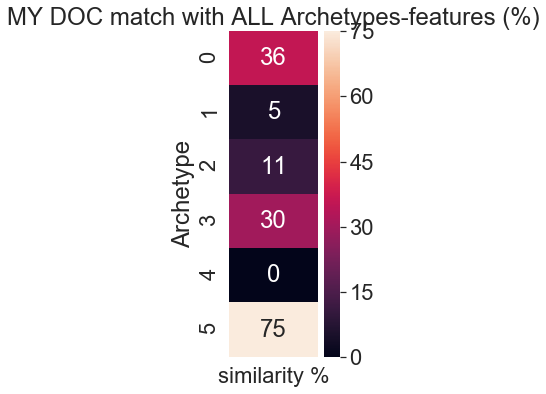

In [289]:
# Measure the similarities between the test vector and the archetypes
sns.set(font_scale = 2)
similarities = ((archetypes.fn[in_common] @ test_vec) * 100).applymap(int)
similarities.columns = ['similarity %']
plt.figure(figsize = (2,6))
sns.heatmap(similarities,annot=True)
plt.ylabel('Archetype')
plt.title('MY DOC match with ALL Archetypes-features (%)')

Text(0.5,1,'Archetypes match with MY DOC-feature subset (%)')

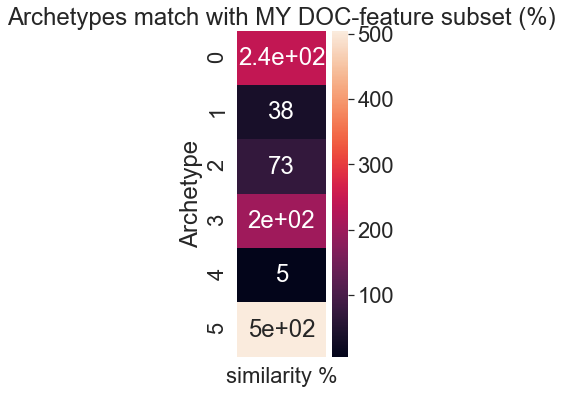

In [290]:
scale_segment = np.sqrt(archetypes.fn.shape[1]/len(test_vec))
sns.set(font_scale = 2)
similarities = ((archetypes.fn[in_common]* scale_segment @ test_vec) * 100).applymap(int)
similarities.columns = ['similarity %']
plt.figure(figsize = (2,6))
sns.heatmap(similarities,annot=True)
plt.ylabel('Archetype')
plt.title('Archetypes match with MY DOC-feature subset (%)')

Text(0.5,1,'Match with Archetypes')

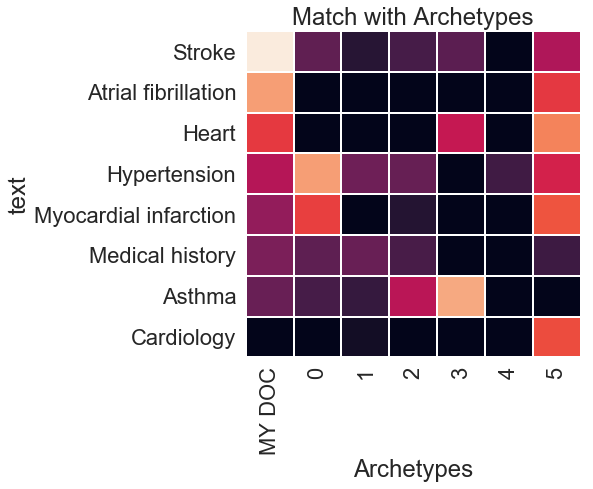

In [292]:
sns.set(font_scale = 2)
compare = archetypes.fn[in_common].T
# mx = np.sqrt(archetypes.fn.shape[1]/len(test_vec))
mx = 1
compare = compare * mx
compare['MY DOC'] = test_vec.loc[in_common].apply(scale)
compare = compare.sort_values(by='MY DOC', ascending = False)[['MY DOC']+list(compare.columns)[:-1]]
plt.figure(figsize = (6,6))
sns.heatmap((compare*100).applymap(np.sqrt),linewidths = 1,cbar=False)
plt.xlabel('Archetypes')
plt.title('Match with Archetypes')

In [293]:
test_vec_expanded = pd.DataFrame(test_vec, index = archetypes.f.columns).apply(scale).fillna(-0.1)
test_vec_expanded.min()

relevance   -0.1
dtype: float64

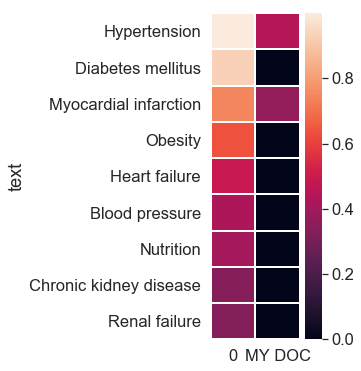

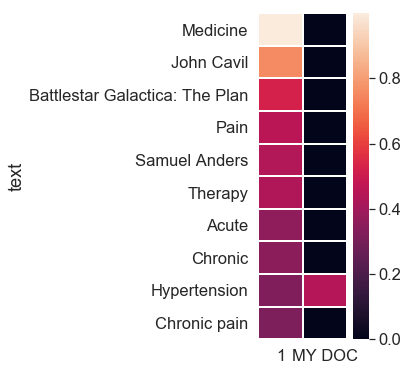

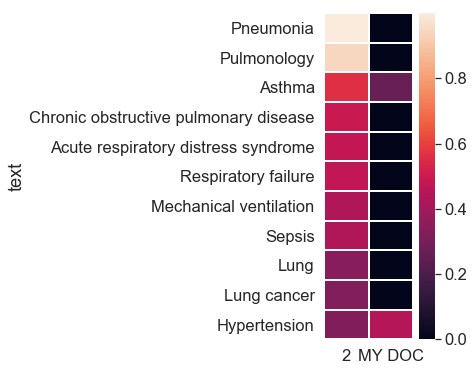

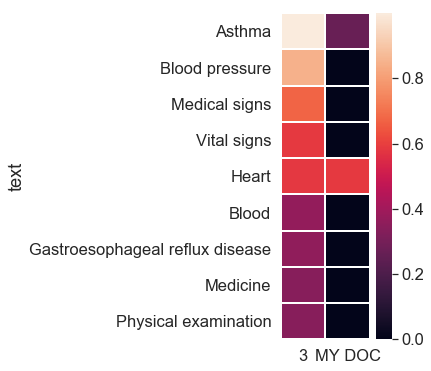

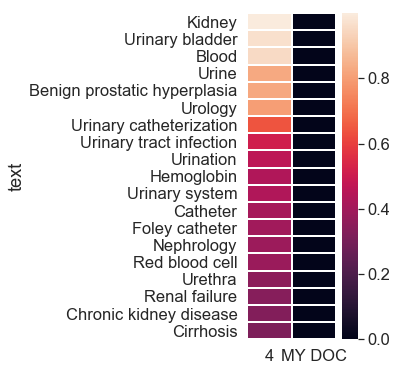

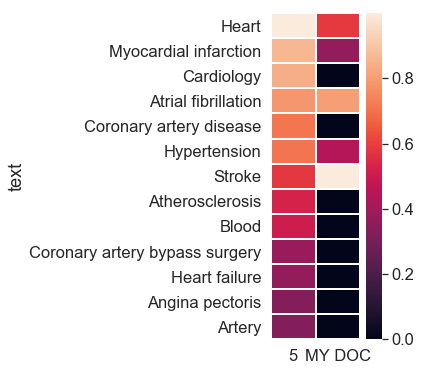

In [300]:
test_vec_expanded = pd.DataFrame(test_vec, index = archetypes.f.columns).apply(scale).fillna(0)

sns.set(font_scale = 1.5)
compare = archetypes.f.T.apply(scale)
compare['MY DOC'] = test_vec_expanded.apply(scale)
for ix in archetypes.f.index:
    cmp = compare.sort_values(by=ix,ascending=False)[[ix,'MY DOC']]
    cmp = cmp[cmp[ix] >0.1]
    plt.figure(figsize = (2,6))
    sns.heatmap(cmp.applymap(np.sqrt),linewidth = 1)
    plt.show()

      

# DAVID TO TEAM: CODE HERE BELOW NOT REQUIRED FOR OUR APPLICATION. ONLY (POTENTIALLY) NEEDED WHEN REPRESENTING A DOCUMENT AS A WEIGHTED SUM OF ARCHETYPES, E.G. FOR FITTING

### 2: Archetypes as basis set

Using the Archetypes as a basis set means to represent any word vector as a weighted sum of archetypes. 
For the general case, the coefficients are obtained through linear regression, which requires some amount of computation. For an orthonormal basis set, this can be replaced by projecting the coefficients, simply by scalar multiplication with the basis vectors.  

*FITTING*

The perhaps most obvious method is the Least Squares Approximation LSA for vectors and matrices. 

**w** = the word vector we want to decsribe as a sum of archetypes, **B** = the basis set (each column an archetype), **c** = the basis set coefficients we are looking for

$$ \mathbf{B  c} = \mathbf{w} $$

The solution:

$$ \mathbf{c} = \mathbf{B^{-1} w} $$

According to LSA, for an overdetermined system, the best approximation to the solution, i.e. with the smallest mean square error, is:

$$ \mathbf{c} = \mathbf{\frac{B^T w}{B^T B} }$$ 

where $(\mathbf{B^T B})^{-1} = \mathbf{N_B}$, a normalization operator. 

The normalized non-orthogonal basis set, **which applies to archetypes**, is

$$ \mathbf{B_{Arch}} = \mathbf{(B^T B)^{-1} B^T} $$


In comparison, for an orthonormal basis set $B_o$, as the one obtained by **Singular Value Decomposition** or any other method constructing a basis set from eigenvectors 

$$\mathbf{B_o^T B_o} = \mathbf{1}$$

and therefore

$$ \mathbf{B_{SVD}} = \mathbf{B_o^T} $$

In [27]:
aaa = wda.archetypes(typ = 'concepts',n_archs = 6, norm = norm_dot)

In [41]:
aaa.fn = aaa.f.T.apply(norm_dot)
aaa.norm_matrix = np.linalg.inv(aaa.fn.T @ aaa.fn)
aaa.arch_basis = aaa.norm_matrix @ aaa.fn.T
aaa.arch_basis

text,2,Abdomen,Abdominal pain,Abnormal psychology,Acinetobacter,Acromion,Acupuncture,Acute,Acute respiratory distress syndrome,Addiction,...,Vermiform appendix,Vital signs,Vitamin D,Vomiting,Vulva,Warfarin,Wheeze,White blood cell,Wrist,Zenker's diverticulum
0,-0.000367,-0.000016,-0.003729,-0.000083,-0.000145,4.694954e-05,0.008671,-0.001766,0.000758,-0.001423,...,-0.000019,-0.033423,-0.005922,-0.004632,-0.000020,0.009354,-0.001935,0.005119,-0.000018,0.008216
1,0.000387,0.000077,-0.001694,-0.000396,-0.007231,-7.903574e-06,-0.002079,-0.008377,-0.027539,-0.000527,...,0.000091,0.277405,0.028152,0.010179,-0.000096,-0.001093,0.010627,-0.002650,0.000125,0.002738
2,0.011524,-0.000008,0.002282,0.004760,-0.000664,-9.421670e-07,0.007882,0.100777,-0.002323,-0.000219,...,-0.000010,-0.021350,0.015840,-0.001384,0.001152,-0.000147,-0.000933,-0.000251,0.000103,-0.000425
3,-0.000713,-0.000009,0.009302,-0.000270,0.000259,-1.440233e-05,0.001233,-0.005708,-0.003324,0.003759,...,-0.000011,-0.011238,0.024300,0.010604,-0.000065,-0.002815,0.001686,-0.001809,-0.000012,-0.002761
4,-0.000112,0.000122,0.016264,-0.000013,-0.000339,-1.722744e-06,-0.000518,-0.000278,-0.001172,0.005666,...,0.000144,-0.016372,-0.003014,-0.000949,-0.000003,-0.000323,-0.000694,0.000766,-0.000008,-0.000521
5,-0.000542,0.000020,-0.000496,-0.000097,0.030943,1.074202e-05,-0.000235,-0.002063,0.118690,-0.000165,...,0.000024,-0.062330,-0.008268,-0.002678,-0.000024,0.000056,-0.002463,0.008588,-0.000032,-0.000791


In [94]:
aaa.arch_basis 

text,2,Abdomen,Abdominal pain,Abnormal psychology,Acinetobacter,Acromion,Acupuncture,Acute,Acute respiratory distress syndrome,Addiction,...,Vermiform appendix,Vital signs,Vitamin D,Vomiting,Vulva,Warfarin,Wheeze,White blood cell,Wrist,Zenker's diverticulum
0,-0.000367,-0.000016,-0.003729,-0.000083,-0.000145,4.694954e-05,0.008671,-0.001766,0.000758,-0.001423,...,-0.000019,-0.033423,-0.005922,-0.004632,-0.000020,0.009354,-0.001935,0.005119,-0.000018,0.008216
1,0.000387,0.000077,-0.001694,-0.000396,-0.007231,-7.903574e-06,-0.002079,-0.008377,-0.027539,-0.000527,...,0.000091,0.277405,0.028152,0.010179,-0.000096,-0.001093,0.010627,-0.002650,0.000125,0.002738
2,0.011524,-0.000008,0.002282,0.004760,-0.000664,-9.421670e-07,0.007882,0.100777,-0.002323,-0.000219,...,-0.000010,-0.021350,0.015840,-0.001384,0.001152,-0.000147,-0.000933,-0.000251,0.000103,-0.000425
3,-0.000713,-0.000009,0.009302,-0.000270,0.000259,-1.440233e-05,0.001233,-0.005708,-0.003324,0.003759,...,-0.000011,-0.011238,0.024300,0.010604,-0.000065,-0.002815,0.001686,-0.001809,-0.000012,-0.002761
4,-0.000112,0.000122,0.016264,-0.000013,-0.000339,-1.722744e-06,-0.000518,-0.000278,-0.001172,0.005666,...,0.000144,-0.016372,-0.003014,-0.000949,-0.000003,-0.000323,-0.000694,0.000766,-0.000008,-0.000521
5,-0.000542,0.000020,-0.000496,-0.000097,0.030943,1.074202e-05,-0.000235,-0.002063,0.118690,-0.000165,...,0.000024,-0.062330,-0.008268,-0.002678,-0.000024,0.000056,-0.002463,0.008588,-0.000032,-0.000791


In [103]:
def basis_err(basis):
    diff = {}
    err = {}
    for row in basis.index:
        diff[row] = dotdf(basis,basis.T[row]) @ basis - basis.T[row]
        err[row] = (diff[row] @ diff[row])
    return {'error':err,'difference':diff}

In [104]:
basis_err(aaa.arch_basis)


{'error': {0: 0.19826879796191826,
  1: 0.11775672984407873,
  2: 0.010315257069752724,
  3: 0.1762807924043379,
  4: 0.0057148623868602914,
  5: 0.07799367723852532},
 'difference': {0: text
  2                                     -0.000060
  Abdomen                               -0.000014
  Abdominal pain                        -0.004101
  Abnormal psychology                    0.000048
  Acinetobacter                          0.001082
  Acromion                               0.000012
  Acupuncture                            0.000858
  Acute                                  0.001023
  Acute respiratory distress syndrome    0.005754
  Addiction                             -0.001611
  Alcoholic liver disease               -0.001540
  Allergy                               -0.000088
  Alzheimer's disease                   -0.002424
  Amiodarone                             0.003521
  Anemia                                -0.004682
  Anesthesia                            -0.000851
  Angina

In [83]:
cowv

,relevance
text,
Kidney,0.981001
Urinary bladder,0.912467
Urology,0.715587
Urinary catheterization,0.703627
Systemic lupus erythematosus,0.637558
Nephrology,0.636369
West Nile virus,0.623735
Lupus erythematosus,0.551911


In [106]:
cowv_proj = dotdf(aaa.arch_basis,cowv)
cowv_proj

,relevance
0,-0.070156
1,-0.058750
2,0.004647
3,0.017584
4,1.230592
5,0.015476


In [111]:
cowv_reconstr = dotdf(cowv_proj.T,aaa.arch_basis)
cowv_reconstr

text,2,Abdomen,Abdominal pain,Abnormal psychology,Acinetobacter,Acromion,Acupuncture,Acute,Acute respiratory distress syndrome,Addiction,...,Vermiform appendix,Vital signs,Vitamin D,Vomiting,Vulva,Warfarin,Wheeze,White blood cell,Wrist,Zenker's diverticulum
relevance,-0.000102,0.000147,0.020542,0.000029,0.000498,-0.000005,-0.001069,0.00061,0.00189,0.007166,...,0.000173,-0.035362,-0.004575,-0.001302,0.000007,-0.001039,-0.001356,0.000839,-0.000016,-0.001441


In [127]:
diff = (cowv_reconstr.T - cowv).fillna(0)
rel_reconstr_err = (diff.T @ diff).values / (cowv.T @ cowv).values
rel_reconstr_err

array([[0.2246253]])

## Mapping WordVec on Archetypes 2:  SVD basis set



In [45]:
w = cowv
B = aaa.arch_basis
# remove rows from the basis set so that it matches w - technical detail enabling scalar multiplication
B_screen = B.loc[w.index]
B_screen , w

KeyError: "None of [Index(['relevance'], dtype='object')] are in the [index]"

In [316]:
 BTBinv = np.linalg.inv(B.T @ B)

# CASE ENDS HERE. BELOW: SNIPPETS & SANDBOX

## DEMO: DOT-PROJECTION OK FOR CONCEPTS

In [4]:
## Normalize the word vector - dot-product / cos-similarity
cowv  = cowv.apply(norm_dot)
cowv

NameError: name 'cowv' is not defined

In [145]:
## Dot-Normalize the archetypes - preparing for mapping cowv

arch_set = wda.archetypes(typ='concepts',n_archs = 6).f.copy()
arch_set = arch_set.T.apply(norm_dot)
arch_set.head(10)

,0,1,2,3,4,5
text,,,,,,
2,0.002958,0.000000,0.000000,0.000000,0.000997,0.000000
Abdomen,0.000000,0.000000,0.000096,0.000112,0.000000,0.000047
Abdominal pain,0.004415,0.008165,0.000000,0.015604,0.000000,0.000271
Abnormal psychology,0.004921,0.000000,0.000000,0.000000,0.000000,0.000000
Acinetobacter,0.000000,0.000843,0.000000,0.000000,0.000000,0.031277
Acromion,0.000010,0.000000,0.000000,0.000000,0.000030,0.000016
Acupuncture,0.003692,0.000000,0.000000,0.000000,0.006355,0.000000
Acute,0.101440,0.000000,0.000000,0.000000,0.000000,0.000000
Acute respiratory distress syndrome,0.000000,0.000000,0.000000,0.000000,0.000000,0.118956


In [263]:
## Map!

nn_map = (cowv.T @ arch_set.loc[cowv.index])
nn_map

,0,1,2,3,4,5
relevance,0.324289,0.521714,0.304836,0.023477,0.390649,0.043066


In [264]:
nn_map = nn_map/ nn_map.values.sum() # Normalize sum to 1 (due to non-orthogonal basis set)
nn_map

,0,1,2,3,4,5
relevance,0.201668,0.324443,0.189571,0.0146,0.242936,0.026782


In [191]:
arch_set2 = wda_a.archetypes(typ='concepts',n_archs =6).f.T.apply(norm_dot)

In [192]:
arch_set2.shape

(361, 6)

In [193]:
arch_set22 = arch_set2.loc[arch_set.index].apply(norm_dot)

In [234]:
## We see that the Archetypes of the full set and the trainingset, respectively, are nearly the same - 
## because the cos-similarity > 0.99 for each archetype. 
aaa = arch_set22.T @ arch_set
aaa

,0,1,2,3,4,5
0,0.077906,0.999170,0.097708,0.064422,0.354563,0.046876
1,0.016394,0.055265,0.067957,0.997076,0.062132,0.028547
2,0.998674,0.067272,0.086536,0.014656,0.046133,0.043077
3,0.041187,0.061104,0.164572,0.027475,0.042533,0.990678
4,0.097688,0.110816,0.995333,0.070613,0.157761,0.272568
5,0.056626,0.366289,0.158609,0.060253,0.999766,0.042221


In [224]:
## NOTE: the archetypes are not in the same order
#@ In order to align them, we must shift the columns of the full-set archetypes so that the max-similarities with the 
## training-set archetypes are on the diagonal
## We do this by identifyin g the positions of the max similarities:
reorder = aaa.T.idxmax().to_dict()
reorder 

{0: 1, 1: 3, 2: 0, 3: 5, 4: 2, 5: 4}

In [235]:
ccc = arch_set.copy()
bbb = arch_set22.copy()
bbb.columns = list(reorder.values())
bbbb= bbb.T.sort_index()

In [242]:
## REORDERING CONFIRMED!
## Now bbbb (full-set) and ccc (training set) archetypes are aligned - the max similarities are on the diagonal 
## We therefore now that 'reorder' is correct.
bbbb @ ccc

,0,1,2,3,4,5
0,0.998674,0.067272,0.086536,0.014656,0.046133,0.043077
1,0.077906,0.999170,0.097708,0.064422,0.354563,0.046876
2,0.097688,0.110816,0.995333,0.070613,0.157761,0.272568
3,0.016394,0.055265,0.067957,0.997076,0.062132,0.028547
4,0.056626,0.366289,0.158609,0.060253,0.999766,0.042221
5,0.041187,0.061104,0.164572,0.027475,0.042533,0.990678


In [266]:
## We now look at how our test-vector is mapped onto the archetypes when it is a part of the corpus (in the full-set)

nn_comp = wda_a.archetypes(typ='concepts',n_archs = 6).o.apply(norm_sum,axis=1).loc[nn]
nn_comp

0    0.312584
1    0.000000
2    0.306001
3    0.000000
4    0.238014
5    0.143400
Name: 147, dtype: float64

In [268]:
## nn_comp sums up to 1 - is normalized. 

nn_comp.sum()

0.9999999999999999

In [282]:
## Now we reorder the mapping of the test-word-vector so that it is aligned with nn_comp

nn_map[[1, 3, 0, 5, 2, 4]]

,1,3,0,5,2,4
relevance,0.324443,0.0146,0.201668,0.026782,0.189571,0.242936


In [283]:
## ... and compare to the distribution across archetypes when it is part of the corpus
pd.DataFrame(nn_comp).T

,0,1,2,3,4,5
147,0.312584,0.0,0.306001,0.0,0.238014,0.1434


In [340]:
aaa = wda.archetypes(typ = 'concepts', n_archs = 6)

In [341]:
aaa.arch_basis

text,2,Abdomen,Abdominal pain,Abnormal psychology,Acinetobacter,Acromion,Acupuncture,Acute,Acute respiratory distress syndrome,Addiction,...,Vital signs,Vitamin D,Vomiting,Vulva,Warfarin,West Nile virus,Wheeze,White blood cell,Wrist,Zenker's diverticulum
0,0.000059,2.661909e-07,0.000108,0.000096,0.000029,2.498536e-07,0.000079,0.001972,0.000102,0.000009,...,0.000506,0.000473,0.000042,2.088140e-05,0.000008,0.000004,0.000025,0.000017,2.720458e-06,0.000016
1,0.000015,4.565841e-07,0.000297,0.000009,0.000062,3.222364e-07,0.000068,0.000183,0.000131,0.000115,...,0.000704,0.000810,0.000381,1.939699e-06,0.000068,0.000019,0.000097,0.000050,5.773090e-07,0.000075
2,0.000009,2.539000e-06,0.000053,0.000009,0.000139,1.993317e-07,0.000031,0.000195,0.000519,0.000018,...,0.005720,0.000741,0.000242,2.060101e-06,0.000026,0.000018,0.000239,0.000102,3.069041e-06,0.000117
3,0.000002,1.759616e-06,0.000238,0.000001,0.000017,4.773922e-08,0.000009,0.000030,0.000060,0.000095,...,0.000328,0.000078,0.000029,3.177159e-07,0.000009,0.000232,0.000017,0.000184,1.996866e-07,0.000014
4,0.000027,5.094381e-07,0.000109,0.000005,0.000033,7.348152e-07,0.000155,0.000112,0.000092,0.000045,...,0.000922,0.000443,0.000148,1.181611e-06,0.000168,0.000017,0.000060,0.000079,5.952931e-07,0.000173
5,0.000004,1.322381e-06,0.000027,0.000004,0.000531,2.987885e-07,0.000009,0.000091,0.002016,0.000008,...,0.001206,0.000180,0.000059,9.680946e-07,0.000006,0.000008,0.000052,0.000151,7.100793e-07,0.000025


In [323]:
cowv

,relevance
text,
Diabetes mellitus,0.418642
Heart,0.392826
Hypertension,0.367451
Medicine,0.345954
Stroke,0.333703
Blood pressure,0.327431
Cystic fibrosis,0.314845
Acupuncture,0.313091


In [342]:
coar = (aaa.arch_basis[cowv.index] @ cowv)
coar

,relevance
0,0.008551
1,0.022561
2,0.010930
3,0.002151
4,0.016430
5,0.003560


In [343]:
coar.values.sum()

0.06418264614478149

In [337]:
cowv.values.sum()

2.8139430738642073

In [21]:
1+1

2

In [22]:
cowv

NameError: name 'cowv' is not defined

In [23]:
aaa = pd.DataFrame()

In [26]:
aaa.sample(1, random_state = None)

ValueError: 'a' must be greater than 0 unless no samples are taken

In [ ]:
1+1